In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/sme-invoicing-assistant


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/sme-invoicing-assistant/.env


True

In [1]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("results/llama3.2-vision_11b-qwen2.5_7b-RTX4090/emails.db")
# conn = sqlite3.connect("src/data/db/llama3.2-vision_11b-qwen2.5_7b-RTX4090/emails.db")

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

OperationalError: unable to open database file

In [5]:
import json

json_file = "results/llama3.2-vision_11b-qwen2.5_7b-RTX4090/full_logs.json"

if "full_logs" in df.columns:
    last_completed = df[df["full_logs"] != ""].iloc[-1]
    full_logs = json.loads(last_completed["full_logs"])
    json.dump(full_logs, open(json_file, "w"), indent=4)
    conn.execute("ALTER TABLE emails DROP COLUMN full_logs")
    conn.execute("VACUUM")
    conn.commit()
    print("full_logs saved to", json_file)
else:
    full_logs = json.load(open(json_file))
    print("full_logs loaded from", json_file)

# Close the connection
conn.close()

full_logs loaded from results/llama3.2-vision_11b-qwen2.5_7b-RTX4090/full_logs.json


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   email_id             2000 non-null   object
 1   sender_email         2000 non-null   object
 2   recipient_email      2000 non-null   object
 3   subject              2000 non-null   object
 4   email_body           2000 non-null   object
 5   attachments          2000 non-null   object
 6   process_status       2000 non-null   object
 7   response             2000 non-null   object
 8   start_time           2000 non-null   object
 9   end_time             2000 non-null   object
 10  total_time           2000 non-null   object
 11  successful_requests  2000 non-null   object
 12  total_tokens         2000 non-null   object
 13  prompt_tokens        2000 non-null   object
 14  completion_tokens    2000 non-null   object
 15  total_cost           2000 non-null   object
dtypes: obj

In [7]:
df.describe()

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,2000,1988,1,1947,2000,1001,3,813,2000,2000,1926,2000,2000,2000,2000,1
top,93185A89130149C0A842968E4AFDCAA2,MichaelJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice I13212,Hi Tanya ! Please find attached payment screen...,,SUCCESS,"{""content"": ""DONE""}",2025-01-21T18:34:06.962783,2025-01-21T18:34:14.048453,1.2577,8,2638,2250,388,0.0
freq,1,3,2000,3,1,1000,1128,1097,1,1,4,1,1,1,1,2000


In [8]:
# plot the distribution of categories
import matplotlib.pyplot as plt


def plot_value_distribution(df2, col="category", top_n=10):
    df2[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df2[col].value_counts()[:top_n])):
        count = df2[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

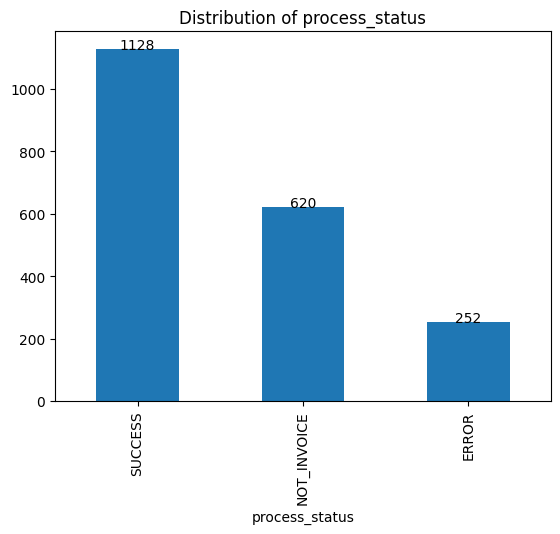

In [9]:
plot_value_distribution(df, "process_status")

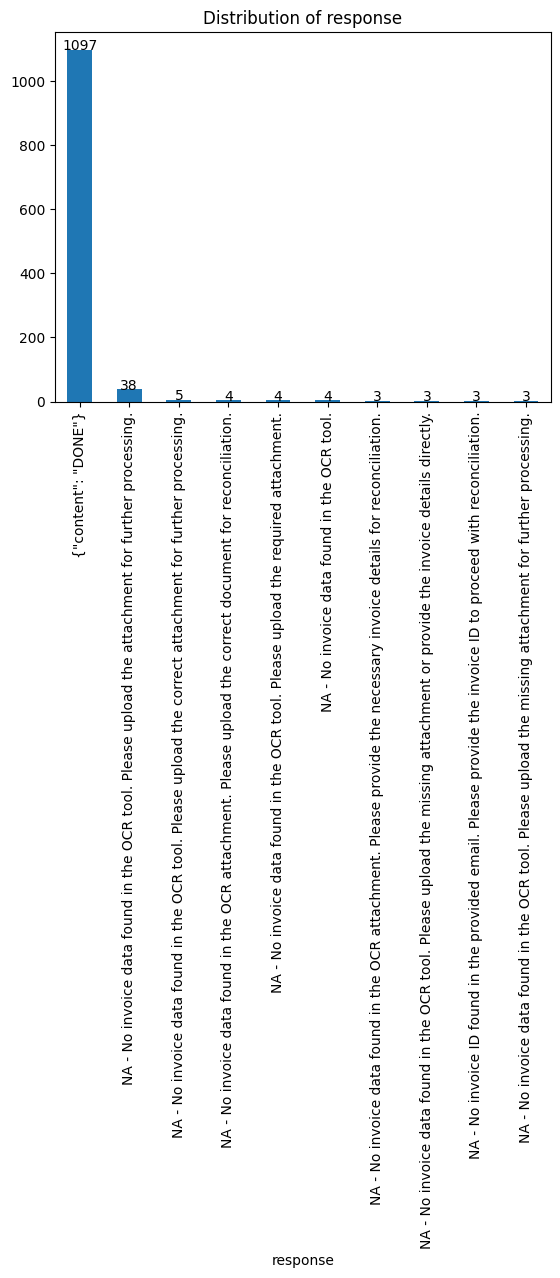

In [10]:
plot_value_distribution(df, "response")

In [11]:
df["end_time"] = pd.to_datetime(df["end_time"])
df["start_time"] = pd.to_datetime(df["start_time"])
df["duration"] = (df["end_time"] - df["start_time"]).dt.total_seconds()

In [12]:
df[["duration", "total_time"]].head()

,duration,total_time
0,7.085670,7.0857
1,7.105284,7.1053
2,38.383077,38.3831
3,7.874619,7.8746
4,45.764491,45.7645


<Axes: ylabel='Frequency'>

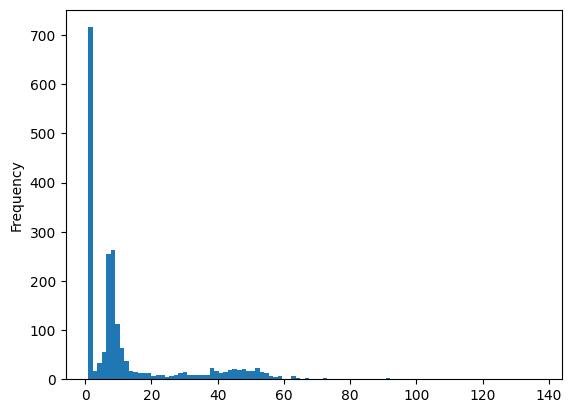

In [13]:
# plot the distribution of duration
df["duration"].plot(kind="hist", bins=100)

In [29]:
df[df["duration"] > 120]

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost,duration
783,B02C8C871A4C4BE6A92D2723E8FEADD6,ChristopherBell@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 10800,Hi Tanya ! Please find attached payment screen...,transaction_784.jpeg,SUCCESS,"Sure, could you please provide the amount ment...",2025-01-21 23:10:03.543777,2025-01-21 23:12:20.625660,137.0819,16209352,11090799786,10623451552,467348234,0.0,137.081883


In [15]:
df["duration"].describe()

count    2000.000000
mean       12.736202
std        16.679474
min         0.903633
25%         1.284450
50%         7.452387
75%        11.515699
max       137.081883
Name: duration, dtype: float64

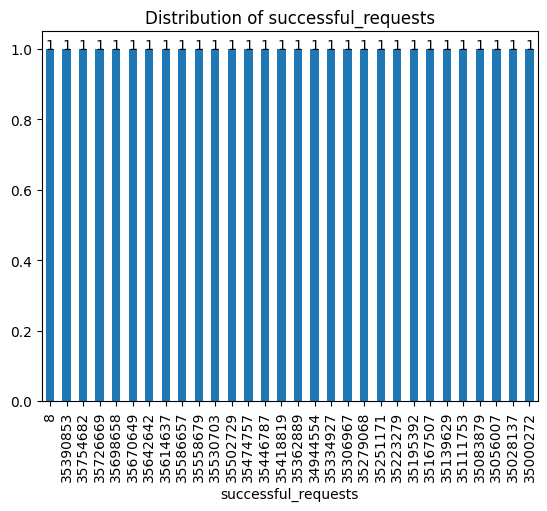

In [16]:
plot_value_distribution(df, "successful_requests", top_n=30)

In [17]:
df["process_status"].value_counts()

process_status
SUCCESS        1128
NOT_INVOICE     620
ERROR           252
Name: count, dtype: int64

In [18]:
success_rate = df["process_status"].value_counts()["SUCCESS"] / len(df)
success_rate

0.564

In [19]:
def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()

In [20]:
power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

In [21]:
power_with_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_7b-RTX4090/power_with_vision.csv"
)
power_without_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_7b-RTX4090/power_without_vision.csv"
)
power_with_vision, power_without_vision

(156.80380000000002, 151.07659999999998)

In [22]:
mean_response_time = df["duration"].mean()
mean_response_time

12.7362022775

In [23]:
average_energy_consumption = (
    (power_with_vision + power_without_vision) / 2 - power_idle
) * mean_response_time
average_energy_consumption

1580.144955203048

In [24]:
df.describe()

,start_time,end_time,duration
count,2000,2000,2000.000000
mean,2025-01-21 23:17:32.953499136,2025-01-21 23:17:45.689701376,12.736202
min,2025-01-21 18:34:06.962783,2025-01-21 18:34:14.048453,0.903633
25%,2025-01-21 21:29:30.432226816,2025-01-21 21:30:12.396681728,1.284450
50%,2025-01-22 00:25:56.660462592,2025-01-22 00:26:04.314511872,7.452387
75%,2025-01-22 01:04:42.547120384,2025-01-22 01:04:48.626737920,11.515699
max,2025-01-22 01:43:12.114817,2025-01-22 01:43:15.717802,137.081883
std,NaN,NaN,16.679474


In [25]:
row = df[df["process_status"] == "NOT_INVOICE"].iloc[0]
row

email_id                                1E31EF68A6414FB7B00846D116D94E7E
sender_email                                 MelissaHamilton@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 80882
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                         transaction_535.jpeg
process_status                                               NOT_INVOICE
response               NA - The provided Invoice ID 80882 does not ma...
start_time                                    2025-01-21 21:42:59.859900
end_time                                      2025-01-21 21:43:16.671294
total_time                                                       16.8114
successful_requests                                              7566780
total_tokens                                                  5197206827
prompt_tokens                                      

In [26]:
full_logs[0]

{'name': 'input',
 'type': 'HumanMessage',
 'content': '\n                Help to reconcile invoices using the following email:\n\n                \n            Sender: RobinLevine@example.com\n            Subject: Payment Confirmation for Invoice ID: 43925\n            Body: Hi Tanya ! Please find attached payment screenshot for Invoice ID: 43925 , Regards Robin Levine\n            Attachment: transaction_1.jpeg\n            Time stamp: NOT_STARTED\n            \n                ',
 'timestamp': '2025-01-22T09:48:19.089141',
 'usage': {'input_tokens': 0,
  'output_tokens': 0,
  'total_tokens': 0,
  'input_token_details': {'audio': 0, 'cache_read': 0},
  'output_token_details': {'audio': 0, 'reasoning': 0}},
 'model_name': '',
 'additional_kwargs': {}}

In [27]:
for i, log in enumerate(full_logs):
    if row["attachments"] in log["content"]:
        print(i)
        break

17985


In [28]:
full_logs[i : i + 5]

[{'name': 'input',
  'type': 'HumanMessage',
  'content': '\n                Help to reconcile invoices using the following email:\n\n                \n            Sender: MelissaHamilton@example.com\n            Subject: Payment Confirmation for Invoice ID: 80882\n            Body: Hi Tanya ! Please find attached payment screenshot for Invoice ID: 80882 , Regards Melissa Hamilton\n            Attachment: transaction_535.jpeg\n            Time stamp: NOT_STARTED\n            \n                ',
  'timestamp': '2025-01-22T09:48:19.089141',
  'usage': {'input_tokens': 0,
   'output_tokens': 0,
   'total_tokens': 0,
   'input_token_details': {'audio': 0, 'cache_read': 0},
   'output_token_details': {'audio': 0, 'reasoning': 0}},
  'model_name': '',
  'additional_kwargs': {}},
 {'name': 'finance_clerk',
  'type': 'AIMessage',
  'content': 'Tool calls to ocr_tool',
  'timestamp': '2025-01-22T07:55:15.166569',
  'usage': {'input_tokens': 297,
   'output_tokens': 26,
   'total_tokens': 323,
